# 04. Time Series Forecasting & Predictive Modeling

---

## Introduction

This notebook moves from historical analysis (EDA, RFM) to predictive analytics. The objective is to build machine learning models that can forecast future business trends and predict specific customer outcomes. This provides forward-looking insights to support strategic planning.

We will focus on two key predictive challenges:

1.  **Sales Forecasting (Time Series):** We will use Facebook's Prophet library to build a time series model. The goal is to forecast Olist's total sales revenue for the next 6-12 months, identifying underlying trends, seasonality, and holiday effects.

2.  **Negative Review Prediction (Classification):** We will build a classification model (such as Logistic Regression or a Decision Tree) to predict the probability of an order receiving a low review score (1 or 2 stars). This model aims to identify high-risk orders proactively, allowing the business to intervene before a poor customer experience occurs.

In [1]:
# --- 2. Setup and Imports ---

# Importing standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
%pip install imblearn

# Adding the project's root directory to the Python path
import sys
sys.path.append('..')

# Importing our custom functions
from src.data_utils import load_processed
from src.viz import plot_scatter, plot_bar, plot_heatmap,plot_count, plot_line, plot_box, plot_stacked_bar, plot_bubble, pie_plot

# Configuring pandas and matplotlib for better display
pd.set_option('display.max_columns', 100)

print("Setup complete.")

/home/lucas/olist-data-analysis-project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Note: you may need to restart the kernel to use updated packages.
Setup complete.


In [2]:
# --- 3. Loading Analytics-Ready Data ---

# Load the final, enriched dataframe from the processed folder
df_analytics = load_processed('analytics_main_data')

# --- Verification ---
print("--- Analytics Data Verification ---")
print(f"DataFrame loaded successfully. Shape: {df_analytics.shape}")
print("\n[INFO - First 5 Columns]")
df_analytics.iloc[:, :5].info() # Display info for the first 5 columns for a quick check
print("\n[HEAD]")
display(df_analytics.head())

Loading processed data from: /home/lucas/olist-data-analysis-project/notebooks/../data/processed/analytics_main_data.parquet
--- Analytics Data Verification ---
DataFrame loaded successfully. Shape: (118310, 44)

[INFO - First 5 Columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118310 entries, 0 to 118309
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  118310 non-null  object        
 1   customer_id               118310 non-null  object        
 2   order_status              118310 non-null  object        
 3   order_purchase_timestamp  118310 non-null  datetime64[ns]
 4   order_approved_at         118295 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 4.5+ MB

[HEAD]


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,order_value,shipping_time_days,total_delivery_time,shipping_delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares,89.97,8,8,0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares,89.97,8,8,0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,housewares,89.97,8,8,0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,perfumery,118.70,13,13,0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,None,None,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP,auto,159.90,9,9,0


---

## 1. Time Series Forecasting: Total Sales

The first predictive task is to forecast the company's total sales revenue. An accurate forecast helps the business plan for inventory, marketing spend, and cash flow. We will use the **Prophet** library (by Facebook) for this task due to its ability to handle seasonality and holidays effectively.

### 1.1. Data Preparation for Prophet

Prophet requires the input dataframe to be in a specific format with two columns:

- ds: The datetime column (datestamp).

- y: The numeric value we want to forecast (in our case, total daily sales).

Our main dataframe is at the item/payment level, meaning a single order_id can appear multiple times. Our first step is to aggregate this data to get the total sales value per day.

In [3]:
df_analytics['order_purchase_timestamp'] = pd.to_datetime(df_analytics['order_purchase_timestamp'])

payments = df_analytics[['order_id', 'order_purchase_timestamp', 'payment_value', 'payment_sequential']].copy()
payments = payments.drop_duplicates(subset=['order_id', 'payment_sequential'])
order_sales = payments.groupby(['order_id', 'order_purchase_timestamp'])['payment_value'].sum().reset_index()

# Define the date as an index for resampling
order_sales = order_sales.set_index('order_purchase_timestamp')

# Resample by Day ('D') and sum the 'payment_value' of all orders for that day
sales_daily = order_sales['payment_value'].resample('D').sum().reset_index()

# --- 3. Rename to Prophet format ---
sales_daily = sales_daily.rename(columns={'order_purchase_timestamp': 'ds', 
                                            'payment_value': 'y'})

# --- 4. Check ---
print("--- Sample of daily sales data (Prophet Format) ---")
print(sales_daily.head())

print(f"\nTime series created with {len(sales_daily)} days of data.")
sales_daily.info()

h_sales = sales_daily.sort_values('y', ascending=False)
print("\n--- Top 5 days with highest sales ---")
print(h_sales.head())

--- Sample of daily sales data (Prophet Format) ---
          ds       y
0 2016-09-04  136.23
1 2016-09-05   75.06
2 2016-09-06    0.00
3 2016-09-07    0.00
4 2016-09-08    0.00

Time series created with 730 days of data.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      730 non-null    datetime64[ns]
 1   y       730 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB

--- Top 5 days with highest sales ---
            ds          y
446 2017-11-24  178450.11
447 2017-11-25   71859.17
701 2018-08-06   65860.43
619 2018-05-16   64742.06
610 2018-05-07   62460.18


---
### 1.2. Visualizing the Time Series Data

Before fitting the model, it is crucial to visualize the data. This allows us to spot overall trends, seasonal patterns, and any significant outliers or anomalies (like massive sales spikes or days with zero sales).

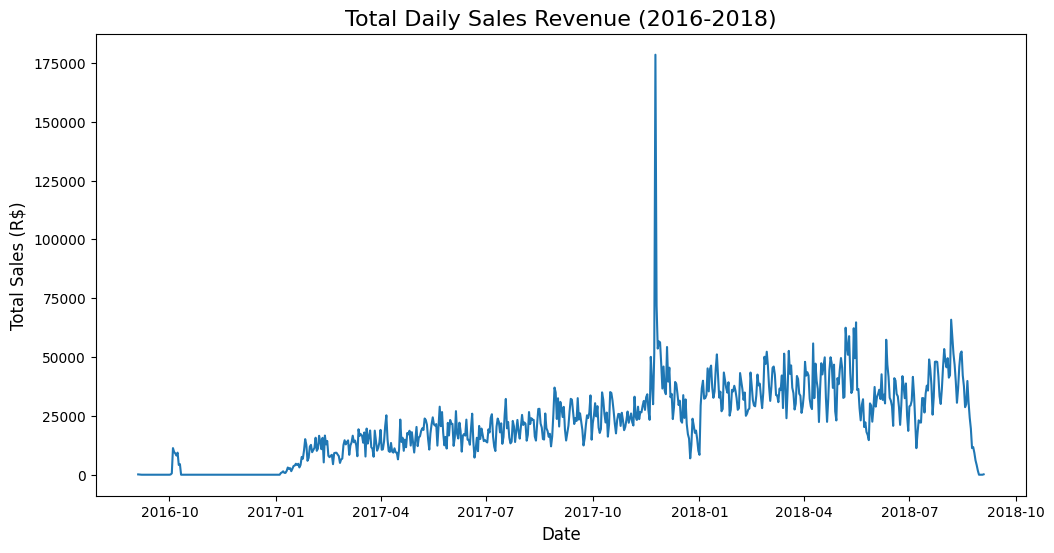

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='ds', y='y', data=sales_daily)
plt.title('Total Daily Sales Revenue (2016-2018)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (R$)', fontsize=12)
plt.show()

---
### 1.3. Model Training & Validation (Train/Test Split)

Before we can trust a model to predict the future, we must test its performance on historical data it has not seen. For time series, we do this by splitting our data based on a "cutoff" date.

- **Train Set:** All data before the cutoff (our model will learn from this).

- **Test Set:** All data after the cutoff (our model will be tested against this).

We will use the last 90 days of our data as the test set.

In [5]:
black_fridays = pd.DataFrame({
  'holiday': 'black_friday',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24']),
  'lower_window': 0, # O evento acontece no dia exato
  'upper_window': 1, # Pode ter um "respingo" no dia seguinte
})


initial_cutoff = '2018-07-31' # From our EDA analysis, we know data after this date is incomplete and unreliable.

sales_daily_clean = sales_daily[sales_daily['ds'] <= initial_cutoff].copy()

cutoff_date = sales_daily_clean['ds'].max() - pd.Timedelta(days=90)

train_data = sales_daily_clean[sales_daily_clean['ds'] <= cutoff_date]
test_data = sales_daily_clean[sales_daily_clean['ds'] > cutoff_date]


model = Prophet(holidays=black_fridays, 
                daily_seasonality=False,
                yearly_seasonality=True,
                weekly_seasonality=True)

model.fit(train_data) # <--- train_data



13:43:29 - cmdstanpy - INFO - Chain [1] start processing
13:43:29 - cmdstanpy - INFO - Chain [1] done processing


### 1.4. Evaluating Model Performance on the Test Set

Now we will use the trained model to predict the 90-day test period (which it has never seen). We will then compare the model's forecast (yhat) against the actual sales data (y) from the test_data to measure its accuracy. We will use **Root Mean Squared Error (RMSE)**, which tells us the average R$ amount our forecast was off by on any given day.

Mean Absolute Error (MAE) on Test Set: R$ 8523.35
The average daily sales in the test set is R$ 34980.47.
Mean Absolute Error (MAE) Percentage on Test Set: 24.37%


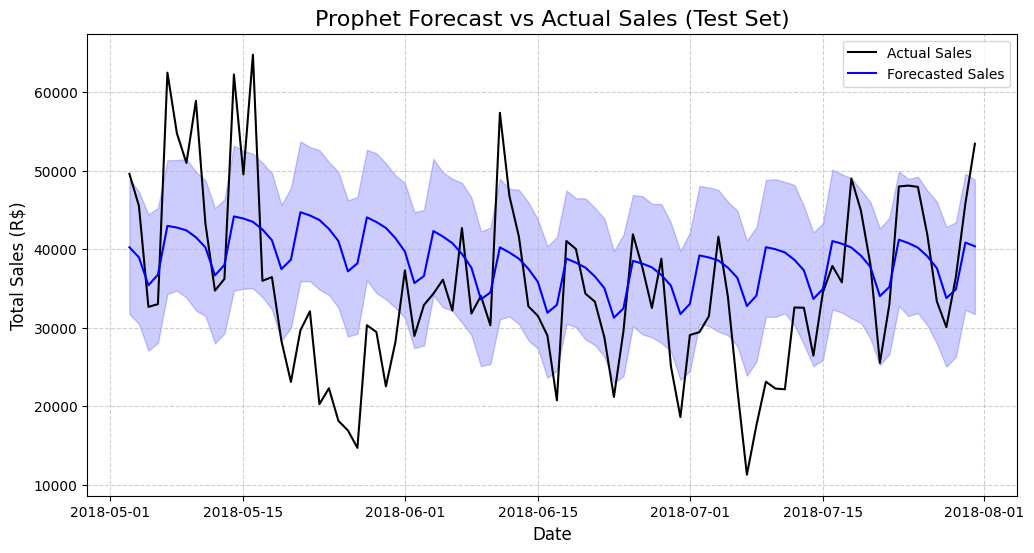

In [6]:
from sklearn.metrics import mean_absolute_error

future_dataframe = test_data[['ds']].copy() #dates from test_data only

forecast = model.predict(future_dataframe)

forecast_to_compare = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Merging with actuals
test_comparison = pd.merge(test_data.rename(columns={'y': 'y_true'}), forecast_to_compare, on='ds')

mae = mean_absolute_error(test_comparison['y_true'], test_comparison['yhat'])
print(f"Mean Absolute Error (MAE) on Test Set: R$ {mae:.2f}")

mae_percent = (mae / test_comparison['y_true'].mean())*100
print(f"The average daily sales in the test set is R$ {test_comparison['y_true'].mean():.2f}.")

print(f"Mean Absolute Error (MAE) Percentage on Test Set: {mae_percent:.2f}%")

# --- 5. Visualizing Forecast vs Actuals ---
plt.figure(figsize=(12, 6))
plt.plot(test_comparison['ds'], test_comparison['y_true'], label='Actual Sales', color='black')
plt.plot(test_comparison['ds'], test_comparison['yhat'], label='Forecasted Sales', color='blue')
plt.fill_between(test_comparison['ds'], test_comparison['yhat_lower'], test_comparison['yhat_upper'], color='blue', alpha=0.2)
plt.title('Prophet Forecast vs Actual Sales (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (R$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### 1.5. Comparison with Baseline Model (Naive Seasonal)

Our evaluation showed that the Prophet model, despite some improvement after data cleaning, still has a **MAE of 24.37%**, which is quite high. The plot indicates that it behaves essentially as a baseline, merely capturing the **weekly seasonality**.

To verify whether Prophet adds any real value, we will compare it with a **naive baseline model**.
We will use a *seasonal baseline*, which assumes that today’s sales will be equal to the sales from the same day of the previous week:

$Y(t) = Y(t - 7)$

If Prophet is not significantly better than this baseline, it cannot be considered useful for this problem.


In [7]:
full_test_period = pd.concat([train_data.tail(7), test_data])

naive_forecast = full_test_period['y'].shift(7)

y_pred_naive = naive_forecast.iloc[7:]

y_true_naive = test_data['y']

mae_naive = mean_absolute_error(y_true_naive, y_pred_naive)
y_true_mean_naive = y_true_naive.mean()  
mae_percent_naive = (mae_naive / y_true_mean_naive) * 100

print(f"Naive Baseline MAE: R$ {mae_naive:.2f}")
print(f"Naive Baseline MAE Percentage: {mae_percent_naive:.2f}%")



Naive Baseline MAE: R$ 8939.74
Naive Baseline MAE Percentage: 25.56%


---

### 1.7. Final Conclusion: Daily Forecasting is Unreliable

Our analysis of time series forecasting leads to a critical conclusion: **forecasting daily sales for this dataset is highly unreliable and not recommended for business operations.**

This conclusion is based on three key findings:

1. **High Volatility:** The actual sales data (black line) is extremely volatile, with random daily spikes and drops (e.g., R$ 65k one day, R$ 25k the next). The model's best attempt is to capture the weekly seasonality (blue line), resulting in a high **Mean Absolute Error (MAE) of 24.37% (R$ 8,523)**.

2. **Insufficient Historical Data:** With less than two years of clean data, the model does not have enough historical cycles to reliably distinguish true annual seasonality (like Black Friday) from random noise. This is the primary reason for its poor predictive power.

3. **No Significant Improvement Over Baseline:** We compared the Prophet model's MAE (24.37%) to a simple "Seasonal Naive" baseline (which predicts sales will be the same as 7 days ago). The baseline's MAE was 25.56%. The complex Prophet model provided almost **no significant improvement** over this "dumb" baseline, proving it fails to add predictive value.

**Business Recommendation:** The company should **not** rely on a daily sales forecast. Given the limitations of this dataset, we will pivot our machine learning efforts to a more viable and valuable problem: predicting customer satisfaction.

---

## 2. Predictive Modeling: Predicting Bad Reviews

In this section, we shift from historical analysis to predictive modeling. While the time series forecast proved unreliable due to data limitations, we can build a robust model to solve a different, high-value problem: **proactively identifying orders that are likely to result in a negative customer review.**

This is a **binary classification** problem. Our goal is to train a model that learns the patterns from past orders. It will use features known at the time of delivery (e.g., shipping delay, freight cost, product category) to predict a simple "Yes/No" answer:

"Is this order at high risk of receiving a 1 or 2-star review?"

If we can predict this accurately, the business can take proactive steps (like offering a voucher or support) to mitigate the bad experience and prevent customer churn.

### 2.1. Feature Engineering & Target Definition

The first step is to create our modeling dataset. We must: 

1. **Define our Target Variable (y):** We will create a new binary column, is_bad_review, which will be 1(Yes) if review_score is 1 or 2, and 0 (No) otherwise. 

2. **Select our Features (X):** We must choose features that are known *before* the review is given. Using a feature like review_comment_message would be "data leakage" (cheating). We will focus on logistic and product features. 

3. **Clean the Data:** Ensure there are no missing values in our selected columns.

In [8]:
# Select features for modeling

numerical_features = ['shipping_time_days', 'shipping_delay_days', 'price', 'freight_value']
categorical_features = ['product_category_name_english', 'customer_state']

target_variable = ['review_score']

model_df = df_analytics[numerical_features + categorical_features + target_variable].copy()

# Clean data

print(f"Tamanho original do dataframe: {len(model_df)}")
model_df = model_df.dropna()
print(f"Tamanho após remover NaNs: {len(model_df)}")

# Binary Target Creation

model_df['is_bad_review'] = model_df['review_score'].apply(lambda x: 1 if x <= 2 else 0)
model_df = model_df.drop('review_score', axis=1)

# --- 4. Verificação ---
print("\n--- Amostra do Dataframe de Modelagem ---")
print(model_df.head())

print("\n--- Distribuição da Target (y) ---")
print(model_df['is_bad_review'].value_counts(normalize=True))

Tamanho original do dataframe: 118310
Tamanho após remover NaNs: 114861

--- Amostra do Dataframe de Modelagem ---
   shipping_time_days  shipping_delay_days   price  freight_value  \
0                   8                    0   29.99           8.72   
1                   8                    0   29.99           8.72   
2                   8                    0   29.99           8.72   
3                  13                    0  118.70          22.76   
4                   9                    0  159.90          19.22   

  product_category_name_english customer_state  is_bad_review  
0                    housewares             SP              0  
1                    housewares             SP              0  
2                    housewares             SP              0  
3                     perfumery             BA              0  
4                          auto             GO              0  

--- Distribuição da Target (y) ---
is_bad_review
0    0.851821
1    0.148179
Name: pr

### 2.2. Preprocessing, Train-Test Split, and Handling Imbalance

Before training our model, we must perform several crucial preprocessing steps.

1. **Categorical Encoding:** Machine learning models only understand numbers. We will convert our categorical features (product_category_name_english, customer_state) into numerical columns using OneHotEncoder. 
2. **Numerical Scaling:** Features on different scales (like price at R$ 200 and shipping_delay_days at 2) can bias the model. We will use StandardScaler to put all numerical features on the same scale. 
3. **Handling Class Imbalance:** Our target variable is highly imbalanced (85% good reviews vs. 15% bad). If we train on this data, the model will be biased toward predicting "good review." To fix this, we will use **RandomUnderSampler** to create a *balanced training set* (50% good, 50% bad) for the model to learn from. 
4. **Train-Test Split:** We will split our data into a training set (to teach the model) and a test set (to evaluate its performance on unseen data).

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

X = model_df.drop('is_bad_review', axis=1)
y = model_df['is_bad_review']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 'stratify' garante que a proporção 85/15 vá para ambos os sets


numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# --- 5. Balancear o *Set de Treino* ---
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_processed, y_train)

print("\n--- (Undersampling) ---")
print("Distribution BEFORE balancing (y_train):")
print(y_train.value_counts(normalize=True))
print("\nDistribution AFTER balancing (y_train_resampled):")
print(y_train_resampled.value_counts(normalize=True))
print(f"\nShape of X_train_resampled: {X_train_resampled.shape}")


--- (Undersampling) ---
Distribution BEFORE balancing (y_train):
is_bad_review
0    0.85182
1    0.14818
Name: proportion, dtype: float64

Distribution AFTER balancing (y_train_resampled):
is_bad_review
0    0.5
1    0.5
Name: proportion, dtype: float64

Shape of X_train_resampled: (27232, 103)


### 2.3. Training the Logistic Regression Model

Now that we have preprocessed our features (scaling and one-hot encoding) and balanced our training data (using undersampling), we are ready to train our first classifier. We will start with **Logistic Regression**, as it is a powerful, fast, and highly interpretable "baseline" model.

We will train the model on our **resampled (50/50) training data**.

Accuracy: 0.7370

Confusion Matrix:
[[15222  4347]
 [ 1695  1709]]

Classification Report:
                 precision    recall  f1-score   support

Good Review (0)       0.90      0.78      0.83     19569
 Bad Review (1)       0.28      0.50      0.36      3404

       accuracy                           0.74     22973
      macro avg       0.59      0.64      0.60     22973
   weighted avg       0.81      0.74      0.76     22973



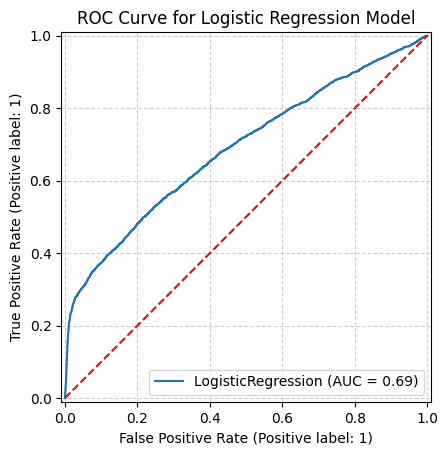

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


log_reg = LogisticRegression(random_state=42, max_iter=1000)

log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = log_reg.predict(X_test_processed)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion Matrix ( [[TN, FP], [FN, TP]])
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report (Precision, Recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Good Review (0)', 'Bad Review (1)']))

 # plot the Roc/ AOC curves

from sklearn.metrics import RocCurveDisplay 

RocCurveDisplay.from_estimator(log_reg, X_test_processed, y_test)
plt.title('ROC Curve for Logistic Regression Model')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() 

### 2.4. Logistic Regression: Baseline Model Results

We trained our first model, Logistic Regression, on the balanced (50/50) training data and evaluated it on the unbalanced (85/15) test set to simulate real-world performance. The results are highly informative.

**Performance on Test Set:**

**1. Classification report**

| Class | Precision | Recall | F1-score | Support |
|---|---:|---:|---:|---:|
| Good Review (0) | 0.90 | 0.78 | 0.83 | 19,569 |
| Bad Review (1)  | 0.28 | 0.50 | 0.36 | 3,404 |
| **Accuracy** |  |  | **0.737** | 22,973 |
| **Macro avg** | 0.59 | 0.64 | 0.60 | 22,973 |
| **Weighted avg** | 0.81 | 0.74 | 0.76 | 22,973 |

- **ROC AUC:** **0.69**

**2. Confusion matrix**
(Format: **Rows = actual**, **Columns = predicted**)

| Actual \ Predicted | Predicted Good (0) | Predicted Bad (1) |
|---|---:|---:|
| **Actual Good (0)** | 15,222 (TN) | 4,347 (FP) |
| **Actual Bad (1)**  | 1,695 (FN)  | 1,709 (TP) |


**The "Business Value":**

The Big Win (Recall): The model achieved a Recall of 0.50 for "Bad Review". This is the most important metric for our goal. It means the model successfully "found" or "flagged" 50% of all bad reviews that occurred. For the business, this is a huge success: we now have a system capable of proactively identifying half of all unhappy customers.

The Trade-Off (Precision): This recall came at the cost of low precision. A Precision of 0.28 means that for every 100 orders the model flagged as "high-risk," only 28 of them actually resulted in a bad review (the other 72 were False Positives).

Overall Conclusion: The Logistic Regression model is a qualified success. It's commercially viable (saving 50% of unhappy customers is a massive win) but technically limited (it creates a high number of false alarms). The low AUC (0.69) suggests our current features (price, delay, category) are only weakly predictive.

Our goal is now to see if a more complex model can improve on these metrics—specifically, if it can **increase the Recall (find more bad reviews)** while also **improving Precision (reduce the false alarms)**.

### 2.5. Training an Advanced Model: Random Forest

Given the limitations of our linear model (Logistic Regression), we will now test a more complex, non-linear model: **Random Forest**. This model is an ensemble of many decision trees and is highly effective at capturing complex interactions between features. Our goal is to improve upon the 50% recall and 28% precision baseline.


--- Random Forest Model Evaluation on Test Set ---
Accuracy: 0.7397

Confusion Matrix:
[[14675  4894]
 [ 1087  2317]]

Classification Report (Random Forest):
                 precision    recall  f1-score   support

Good Review (0)       0.93      0.75      0.83     19569
 Bad Review (1)       0.32      0.68      0.44      3404

       accuracy                           0.74     22973
      macro avg       0.63      0.72      0.63     22973
   weighted avg       0.84      0.74      0.77     22973


Plotting the ROC Curve...


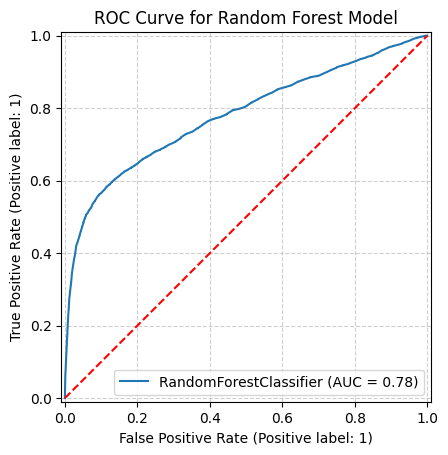

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced') 

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_processed)

print("\n--- Random Forest Model Evaluation on Test Set ---")

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Classification Report (Precision, Recall, F1)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Good Review (0)', 'Bad Review (1)']))

# --- 4. Plotting the ROC/AUC Curve ---
print("\nPlotting the ROC Curve...")
RocCurveDisplay.from_estimator(rf_model, X_test_processed, y_test)
plt.title('ROC Curve for Random Forest Model')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('roc_curve_random_forest.png', dpi=600)
plt.show()

### 2.6. Model Comparison & Final Selection

We have trained two models: a simple linear model (Logistic Regression) to act as our baseline, and a more complex ensemble model (Random Forest) to see if we could improve performance. The results clearly show a superior model.

**Model Performance Comparison (Target: "Bad Review")**

| Metric    | Logistic Regression (Baseline) | Random Forest (Champion) | Improvement |
|---|---:|---:|---:|
| ROC AUC   | 0.69 | 0.78 | Significant |
| Recall    | 0.50 (50%) | 0.68 (68%) | Excellent |
| Precision | 0.28 (28%) | 0.32 (32%) | Slight |
| F1-Score  | 0.36 | 0.44 | Good |


**Analysis & Final Model Selection:**

The Random Forest classifier is the clear winner and our final "champion" model. The improvements are not just statistical, they translate directly into business value:

- **Superior Predictive Power (AUC):** With an AUC of 0.78 (up from 0.69), the Random Forest is far better at discriminating between satisfied and dissatisfied customers.

- **Massive Increase in Business Value (Recall):** This is the most critical metric. Our baseline model found 50% of all bad reviews. The Random Forest model finds 68% of all bad reviews. In our test set, this translates to proactively identifying an additional 608 unhappy customers who would have otherwise been missed.

- **Improved Efficiency (Precision):** The model also saw a slight increase in precision (from 28% to 32%). While it still generates a high number of false positives (4,894), the trade-off is exceptionally good: the low cost of sending a proactive "sorry" email/voucher to ~5k customers is easily worth the high reward of saving ~2.3k customers who are confirmed to be at high risk of churning.

**Conclusion:** We select the **Random Forest** model as our final production candidate. It provides a powerful and commercially viable tool to identify and mitigate almost **70%** of negative customer experiences before they happen.